<a href="https://colab.research.google.com/github/rhoadesScholar/JeffsMatland/blob/master/New_and_Old_FOOOF_Notebook_CLW_JLR_20210224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FOOOF Notebook

This notebook analyses power spectra through the original ('old') FOOOF software created by Bradley Voytek's lab and a new version (code changes embedded in this notebook) created by Jeff Rhoades and Carol Wilkinson. 

To download FOOOF and review documentation from the Voytek Lab go here:
https://fooof-tools.github.io/fooof/index.html

Reference for original FOOOF: Donoghue T, Haller M, Peterson E, Varma P, Sebastian P, Gao R, Noto T, Lara AH, Wallis JD, Knight RT, Shestyuk A, Voytek B. Parameterizing neural power spectra into periodic and aperiodic components. Nature Neuroscience (in press)

https://fooof-tools.github.io/fooof/reference.html

In [ ]:
#IMPORTS
%matplotlib inline
import numpy as np
import fooof
import random
import csv
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
from scipy.optimize import curve_fit

In [ ]:
#PREPARE DATA

#load PSD files - columns should include frequency, studyID, power (not logged normalized).
#Can pull in csv with multiple power calculations using different regions of interests - specific column is chosen below. 
df=pd.read_csv('/Users/carol/Dropbox (BCH)/Beta Project/FOOOF Testing/CLAM_ISPonly.csv')
df.head(n=5)

,Unnamed: 0,StudyID,Age_months,frequency,wholeavg,wholeavg2,frontalavg,temporalavg,Sex,Risk,Group
0,3753,4131,12,0.0,1.711477,1.665261,1.548912,1.623014,F,1,High Risk/No Autism
1,3754,4131,12,0.1,2.047068,1.992973,1.859437,1.942551,F,1,High Risk/No Autism
2,3755,4131,12,0.2,2.382659,2.320685,2.169961,2.262088,F,1,High Risk/No Autism
3,3756,4131,12,0.3,2.718250,2.648398,2.480486,2.581624,F,1,High Risk/No Autism
4,3757,4131,12,0.4,3.053841,2.976110,2.791011,2.901161,F,1,High Risk/No Autism


In [ ]:
#Limit frequency bands based on your sample rate and window size and frequencies of interest
bottom = df['frequency'] >= 3
top = df['frequency'] < 55
df1 = df[bottom & top].sort_values(by='frequency')
df1['frequency'] = df1['frequency'].astype('float64')

df1.columns

In [ ]:
#create Outcome and Risk Group dataframes if desired
HR = df1.groupby('Risk').get_group(1)
LR = df1.groupby('Risk').get_group(2)
HRA = df1.groupby('Group').get_group('High Risk/Autism')
HRNA = df1.groupby('Group').get_group('High Risk/No Autism')
LRC = df1.groupby('Group').get_group('Low Risk/No Autism')

In [ ]:
#grab specific columns

columns1 = ['StudyID', 'Age_months', 'frequency', 'frontalavg', 'Sex']
columns2 = ['StudyID', 'Age_months', 'Sex', 'Risk', 'Group']
dfEEGall = df1[columns1]
dfHR = HR[columns1]
dfLR = LR[columns1]
dfHRA = HRA[columns1]
dfHRNA = HRNA[columns1]
dfLRC = LRC[columns1]
dfsummary = df1[columns2]
dfsummary = dfsummary.drop_duplicates(subset=None, keep='first', inplace=False)
dfsummary.dtypes

StudyID        int64
Age_months     int64
Sex           object
Risk           int64
Group         object
dtype: object

In [ ]:
#define FOOOOF parameters (see FOOOF github for guidelines around these)
freq_range=[3, 55] 
peak_width_limits=[0.5, 18.0]
max_n_peaks = 7
peak_threshold = 2

#Note - original fooof uses an ap_percentile_thresh of 0.025, however this leads to errors in new fooof. 
#The percentile threshold is used to select points from a flat spectrum for an initial aperiodic fit
#Points are selected at a low percentile value to restrict to non-peak points
#Documentation here: https://fooof-tools.github.io/fooof/_modules/fooof/objs/fit.html

#During development of new fooof, threshold was set at 10-20. For this dataset 20 worked best. 
ap_percentile_thresh = 20

In [ ]:
#BEGIN DEFINING NEW METHODS, ADD SOME TO FOOOF CLASS (i.e. replacements)
def _new_robust_ap_fit(self, freqs, power_spectrum):
    #REPLACES original function --> fooof.FOOOF._robust_ap_fit(), with editing to make standalone
    """Fit the aperiodic component of the power spectrum robustly, ignoring outliers.
    Parameters
    ----------
    freqs : 1d array
        Frequency values for the power spectrum, in linear scale.
    power_spectrum : 1d array
        Power values, in log10 scale.
    Returns
    -------
    aperiodic_params : 1d array
        Parameter estimates for aperiodic fit.
    Raises
    ------
    FitError
        If the fitting encounters an error.
    """

    # Do a quick, initial aperiodic fit
    popt = self._simple_ap_fit(freqs, power_spectrum)
    initial_fit = fooof.sim.gen.gen_aperiodic(freqs, popt)#edited to make standalone (fooof call)

    # Flatten power_spectrum based on initial aperiodic fit
    flatspec = power_spectrum - initial_fit

    # OLD: Flatten outliers, defined as any points that drop below 0
    # flatspec[flatspec < 0] = 0#ORIGINAL
    # NEW: Increase baseline to prevent fitting negative values
    if min(flatspec) < 0:
        flatspec -= min(flatspec)

    # Use percentile threshold, in terms of # of points, to extract and re-fit
    perc_thresh = np.percentile(flatspec, self._ap_percentile_thresh)#self._ap_percentile_thresh was set to 10 during dev and may cause errors if lowered (not sure why...)
    perc_mask = flatspec <= perc_thresh
    freqs_ignore = freqs[perc_mask]
    spectrum_ignore = power_spectrum[perc_mask]

    # Second aperiodic fit - using results of first fit as guess parameters
    #  See note in _simple_ap_fit about warnings
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            aperiodic_params, _ = curve_fit(fooof.core.funcs.get_ap_func(self.aperiodic_mode),#editted to make standalone
                                            freqs_ignore, spectrum_ignore, p0=popt,
                                            maxfev=self._maxfev, bounds=self._ap_bounds)
    except RuntimeError:
        raise fooof.core.errors.FitError("Model fitting failed due to not finding "#editted to make standalone
                                        "parameters in the robust aperiodic fit.")
    except TypeError:
        raise fooof.core.errors.FitError("Model fitting failed due to sub-sampling in the robust aperiodic fit.")#editted to make standalone

    return aperiodic_params

#ADD to FOOOF:
setattr(fooof.FOOOF, '_new_robust_ap_fit', _new_robust_ap_fit)

In [ ]:
def new_fit(self, freqs=None, power_spectrum=None, freq_range=None):
    #REPLACES original function --> fooof.FOOOF.fit(), with editing to make standalone
    """Fit the full power spectrum as a combination of periodic and aperiodic components.
    Parameters
    ----------
    freqs : 1d array, optional
        Frequency values for the power spectrum, in linear space.
    power_spectrum : 1d array, optional
        Power values, which must be input in linear space.
    freq_range : list of [float, float], optional
        Frequency range to restrict power spectrum to. If not provided, keeps the entire range.
    Raises
    ------
    NoDataError
        If no data is available to fit.
    FitError
        If model fitting fails to fit. Only raised in debug mode.
    Notes
    -----
    Data is optional, if data has already been added to the object.
    """

    # If freqs & power_spectrum provided together, add data to object.
    if freqs is not None and power_spectrum is not None:
        self.add_data(freqs, power_spectrum, freq_range)
    # If power spectrum provided alone, add to object, and use existing frequency data
    #   Note: be careful passing in power_spectrum data like this:
    #     It assumes the power_spectrum is already logged, with correct freq_range
    elif isinstance(power_spectrum, np.ndarray):
        self.power_spectrum = power_spectrum

    # Check that data is available
    if not self.has_data:
        raise NoDataError("No data available to fit, can not proceed.")

    # Check and warn about width limits (if in verbose mode)
    if self.verbose:
        self._check_width_limits()

    # In rare cases, the model fails to fit, and so uses try / except
    try:

        # Fit the aperiodic component
#         self.aperiodic_params_ = self._robust_ap_fit(self.freqs, self.power_spectrum)#ORIGINAL
        self.aperiodic_params_ = self._new_robust_ap_fit(self.freqs, self.power_spectrum)#NEW
        self._ap_fit = fooof.sim.gen.gen_aperiodic(self.freqs, self.aperiodic_params_)#editted to make standalone (fooof call)

        # Flatten the power spectrum using fit aperiodic fit
        self._spectrum_flat = self.power_spectrum - self._ap_fit
        
        self._spectrum_flat[self._spectrum_flat < 0] = 0#NEW

        # Find peaks, and fit them with gaussians
        self.gaussian_params_ = self._fit_peaks(np.copy(self._spectrum_flat))

        # Calculate the peak fit
        #   Note: if no peaks are found, this creates a flat (all zero) peak fit
        self._peak_fit = fooof.sim.gen.gen_periodic(self.freqs, np.ndarray.flatten(self.gaussian_params_))#editted to make standalone

        # Create peak-removed (but not flattened) power spectrum
        self._spectrum_peak_rm = self.power_spectrum - self._peak_fit

        # Run final aperiodic fit on peak-removed power spectrum
        #   This overwrites previous aperiodic fit, and recomputes the flattened spectrum
        self.aperiodic_params_ = self._simple_ap_fit(self.freqs, self._spectrum_peak_rm)
        self._ap_fit = fooof.sim.gen.gen_aperiodic(self.freqs, self.aperiodic_params_)#editted to make standalone
        self._spectrum_flat = self.power_spectrum - self._ap_fit

        # Create full power_spectrum model fit
        self.fooofed_spectrum_ = self._peak_fit + self._ap_fit

        # Convert gaussian definitions to peak parameters
        self.peak_params_ = self._create_peak_params(self.gaussian_params_)

        # Calculate R^2 and error of the model fit
        self._calc_r_squared()
        self._calc_error()

    except fooof.core.errors.FitError:#editted to make standalone

        # If in debug mode, re-raise the error
        if self._debug:
            raise

        # Clear any interim model results that may have run
        #   Partial model results shouldn't be interpreted in light of overall failure
        self._reset_data_results(clear_results=True)

        # Print out status
        if self.verbose:
            print("Model fitting was unsuccessful.")

#ADD to FOOOF:    
setattr(fooof.FOOOF, 'new_fit', new_fit)

In [ ]:
#FUNCTIONS FOR COMPARING OLD AND NEW FITS for different ages in the dataframes. 
#Converts ages to strings for graphing later in notebook. 
def getSpectrums(df1, sampNum, ages=[['three', 3],['six', 6],['nine', 9],['twelve', 12]]):
    # ages is list of pairs [['word', #], ['word', #]]
    # create vectors for testing fooof 
    # get 1 study ID
    if ages == None:
        ages = [['three', 3],['six', 6],['nine', 9],['twelve', 12]]
    spectrums = dict()
    success = dict()
    freqs = dict()
    try:
        test = df1.groupby('StudyID').get_group(sampNum)
        for age in ages:
            success[age[0]] = True
            try:
                #specify here which power column in your dataframe you are using - eg. 'frontalavg'
                spectrums[age[0]] = test.groupby('Age_months').get_group(age[1])['frontalavg'].to_numpy()
                freqs[age[0]] = test.groupby('Age_months').get_group(age[1])['frequency'].to_numpy()
            except:
                success[age[0]] = False
        success = any(success.values())
    except:
        print('getSpectrums() failed on Subject ID: ' + str(sampNum))
        freqs = []
        success = False
    return spectrums, freqs, success

In [ ]:
def compareFits(sampNum, spectrums, freqs, freq_range=freq_range, peak_width_limits=peak_width_limits, silent=False):
    ages = spectrums.keys()
    if not silent:
        N = len(ages)    
        fig = plt.figure(figsize=(20,15))
        axs = fig.subplots(N,2)
        if len(axs.shape) < 2:#results from only one age point
            axs = np.array([axs[0], axs[1]], ndmin=2)
    fm = dict()
    fm0 = dict()
    for i, age in enumerate(ages):
        fm[age] = fooof.FOOOF(peak_width_limits=peak_width_limits, max_n_peaks = max_n_peaks,
                              peak_threshold = peak_threshold)
        fm[age]._ap_percentile_thresh = ap_percentile_thresh
        fm[age].new_fit(freqs[age], spectrums[age], freq_range)
        
        fm0[age] = fooof.FOOOF(peak_width_limits=peak_width_limits, max_n_peaks = max_n_peaks,
                              peak_threshold = peak_threshold)
#       fm0[age]._ap_percentile_thresh = ap_percentile_thresh #(see above) keeping it consistent, 
#                                        comment out to see fully original results using ap_percentile_thresh = 0.025
        fm0[age].fit(freqs[age], spectrums[age], freq_range)
        
        if not silent:
            try:
                axs[i,0].plot(fm[age].freqs, fm[age]._ap_fit, label='Final AP fit',  linewidth=2)
                axs[i,0].plot(fm[age].freqs, fm[age].power_spectrum, label='Original Spectrum',  linewidth=2)
                axs[i,0].plot(fm[age].freqs, fm[age].fooofed_spectrum_, label='Final combined fit',  linewidth=2)
                axs[i,0].set_title('New Fit of ' + str(age) + ' months (R^2=' 
                                   + str(fm[age].r_squared_) + ', Error=' + str(fm[age].error_) + ')')
                axs[i,0].legend()
            except:
                print('Failed to plot new fit of #' + str(sampNum) + ' @ ' + age + ' months')
            
            try:
                axs[i,1].plot(fm0[age].freqs, fm0[age]._ap_fit, label='Final AP fit',  linewidth=2)
                axs[i,1].plot(fm0[age].freqs, fm0[age].power_spectrum, label='Original Spectrum',  linewidth=2)
                axs[i,1].plot(fm0[age].freqs, fm0[age].fooofed_spectrum_, label='Final combined fit',  linewidth=2)
                axs[i,1].set_title('Original FOOOF of ' + str(age) + ' months (R^2=' 
                                   + str(fm0[age].r_squared_) + ', Error=' + str(fm0[age].error_) + ')')
                axs[i,1].legend()
            except:
                print('Failed to plot old fit of #' + str(sampNum) + ' @ ' + age + ' months')
    if not silent:
        fig.suptitle('Subject ID: ' + str(sampNum))
        fig.show()
    return fm, fm0

In [ ]:
#COMPARISON FOR FITS FOR DIFFERENT AGES
def getFitCompare(df1, sampNum=None, exclude=[], freq_range=freq_range, 
                  peak_width_limits=peak_width_limits, ages=None, silent=False):
#      ages is list of pairs [['word', #], ['word', #]]
    sampNums = set(df1.StudyID) - set(exclude)
    if sampNum == None or sampNum not in sampNums:
        sampNum = random.sample(sampNums,1)[0] #RANDOM DRAW
    success = False
    while not success:
        spectrums, freqs, success = getSpectrums(df1, sampNum, ages=ages)
        if not success:
            sampNums = sampNums - set([sampNum])
            if len(sampNums) == 0:
                return False, False, False, False, False
            sampNum = random.sample(sampNums,1)[0] #RANDOM DRAW
    fm, fm0 = compareFits(sampNum, spectrums, freqs, silent=silent,
                             freq_range=freq_range, peak_width_limits=peak_width_limits)
    return sampNum, fm, fm0, freqs, spectrums

In [ ]:
#BATCH COMPARISON
def groupCompare(df1, num='all', reqAges=None):
    #num = NUMBER OF SAMPLES
    #reqAges = list of pairs: [['word', #], ['word', #]]
    err = dict()
    err0 = dict()
    fm = dict()
    fm0 = dict()
    freqs = dict()
    fits = ['old', 'new']
    fitDF = pd.DataFrame()
    aperiodicDF = pd.DataFrame()    
    peaksDF = pd.DataFrame()
    if num=='all':
        sampNums = list(set(df1['StudyID']))
        num = len(sampNums)
    else:
        sampNums = [None for i in range(num)]
    for i in range(num):
        newSampNum, newfm, newfm0,_,_ = getFitCompare(df1, sampNum=sampNums[i], 
                                                        exclude=sampNums[:i], ages=reqAges, silent=True)
        if not newSampNum:
            break
        else:
            sampNums[i], fm[i], fm0[i] = newSampNum, newfm, newfm0
            theseAges = list(fm[i].keys())
            for age in theseAges:                
                this = dict()
                this['Age_months'] = [age for f in fm[i][age].freqs]
                this['StudyID'] = [sampNums[i] for f in fm[i][age].freqs]
                this['frequency'] = fm[i][age].freqs
                this['spectrum'] = fm[i][age].power_spectrum
                
                thisOld = this
                thisOld['fooof'] = fm0[i][age].fooofed_spectrum_
                thisOld['peak_fit'] = fm0[i][age]._peak_fit
                thisOld['ap_fit'] = fm0[i][age]._ap_fit
                thisOld['sqerror'] = (fm0[i][age].power_spectrum - fm0[i][age].fooofed_spectrum_)**2
                thisOld['fit_version'] = ['old' for f in fm[i][age].freqs]                
                thisOldDF = pd.DataFrame(data=thisOld)
                fitDF = fitDF.append(thisOldDF)
                
                thisNew = this
                thisNew['fooof'] = fm[i][age].fooofed_spectrum_                
                thisOld['peak_fit'] = fm[i][age]._peak_fit
                thisOld['ap_fit'] = fm[i][age]._ap_fit
                thisNew['sqerror'] = (fm[i][age].power_spectrum - fm[i][age].fooofed_spectrum_)**2
                thisNew['fit_version'] = ['new' for f in fm[i][age].freqs]                
                thisNewDF = pd.DataFrame(data=thisNew)
                fitDF = fitDF.append(thisNewDF)
                                
                thisBG = dict()
                thisBG['StudyID'] = [sampNums[i] for f in fits]
                thisBG['Age_months'] = [age for f in fits]
                thisBG['fit_version'] = [f for f in fits]
                thisBG['aperiodic_offset'] = [fm0[i][age].aperiodic_params_[0], fm[i][age].aperiodic_params_[0]]
                thisBG['aperiodic_exponent'] = [fm0[i][age].aperiodic_params_[1], fm[i][age].aperiodic_params_[1]]#assumes non-knee ap fit
                thisBG['n_peaks'] = [fm0[i][age].n_peaks_, fm[i][age].n_peaks_]
                thisBG['error'] = [fm0[i][age].error_, fm[i][age].error_]
                thisBG['r_squared'] = [fm0[i][age].r_squared_, fm[i][age].r_squared_]
                thisBGDF = pd.DataFrame(data=thisBG)
                aperiodicDF = aperiodicDF.append(thisBGDF)

                thesePeaks = dict()
                thesePeaks['StudyID'] = [sampNums[i] for t in range(fm0[i][age].peak_params_.shape[0] + fm[i][age].peak_params_.shape[0])]
                thesePeaks['Age_months'] = [age for t in range(fm0[i][age].peak_params_.shape[0] + fm[i][age].peak_params_.shape[0])]
                thesePeaks['fit_version'] = ['old' for t in range(fm0[i][age].peak_params_.shape[0])] + ['new' for t in range(fm[i][age].peak_params_.shape[0])]
                thesePeaks['center_freq'] = np.append(fm0[i][age].peak_params_[:,0], fm[i][age].peak_params_[:,0])
                thesePeaks['peak_height'] = np.append(fm0[i][age].peak_params_[:,1], fm[i][age].peak_params_[:,1])
                thesePeaks['peak_bandwidth'] = np.append(fm0[i][age].peak_params_[:,2], fm[i][age].peak_params_[:,2])
                thesePeaks['peak_number'] = [p for p in range(fm0[i][age].peak_params_.shape[0])] + [p for p in range(fm[i][age].peak_params_.shape[0])]
                thesePeaksDF = pd.DataFrame(data=thesePeaks)
                peaksDF = peaksDF.append(thesePeaksDF)
                            
                if not age in freqs.keys() or len(freqs[age]) > len(fm[i][age].freqs):
                    freqs[age] = fm[i][age].freqs
                thisErr = np.array((fm[i][age].power_spectrum - fm[i][age].fooofed_spectrum_)**2, ndmin=2)
                thisErr0 = np.array((fm0[i][age].power_spectrum - fm0[i][age].fooofed_spectrum_)**2, ndmin=2)
                
                if age in err.keys():    
                    if not thisErr.shape[1] == err[age].shape[1]:#TRY TO CATCH WEIRD SPECTRUMS HERE (e.g. 4223 @ 6months)
                        if fm[i][age].freqs[0] == fm[i][age].freqs[err[age].shape[1]]:
                            thisErr = thisErr[:,0:err[age].shape[1]]
                            thisErr0 = thisErr0[:,0:err0[age].shape[1]]
                        elif fm[i][age].freqs[0] == fm[i][age].freqs[1]:
                            thisErr = thisErr[:,::2]
                            thisErr0 = thisErr0[:,::2]
                        else:
                            print('Error (ID#age): ' + str(sampNums[i]) + age)                        
                    err[age] = np.append(err[age], thisErr, axis=0)
                    err0[age] = np.append(err0[age], thisErr0, axis=0)
                else:
                    err[age] = thisErr
                    err0[age] = thisErr0
    ages = list(err.keys())
    fig = plt.figure(figsize=(20,15))
    axs = fig.subplots(len(ages),1)
    if len(ages) <= 1:
        axs = [axs]
    for i, age in enumerate(ages):
        if err[age].shape[0] > 1:
            dif = np.mean(err[age],axis=0)
            dif0 = np.mean(err0[age],axis=0)
        else:
            dif = np.squeeze(err[age])
            dif0 = np.squeeze(err0[age])
        axs[i].plot(freqs[age], dif0, 
                    label='Old Fit RMSE (mean = ' + str(np.mean(dif0)) + ')',  linewidth=3)
        axs[i].plot(freqs[age], dif, 
                    label='New Fit RMSE (mean = ' + str(np.mean(dif)) + ')',  linewidth=3)
        axs[i].set_title(str(age) + ' months (N = ' + str(err[age].shape[0]) + ')')
        axs[i].legend()
        axs[i].set_xlabel('Hz')
        axs[i].set_ylabel('MSE of log(Power)')
    fig.show()
    return err, err0, fm, fm0, sampNums, fitDF, aperiodicDF, peaksDF

/Users/carol/anaconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


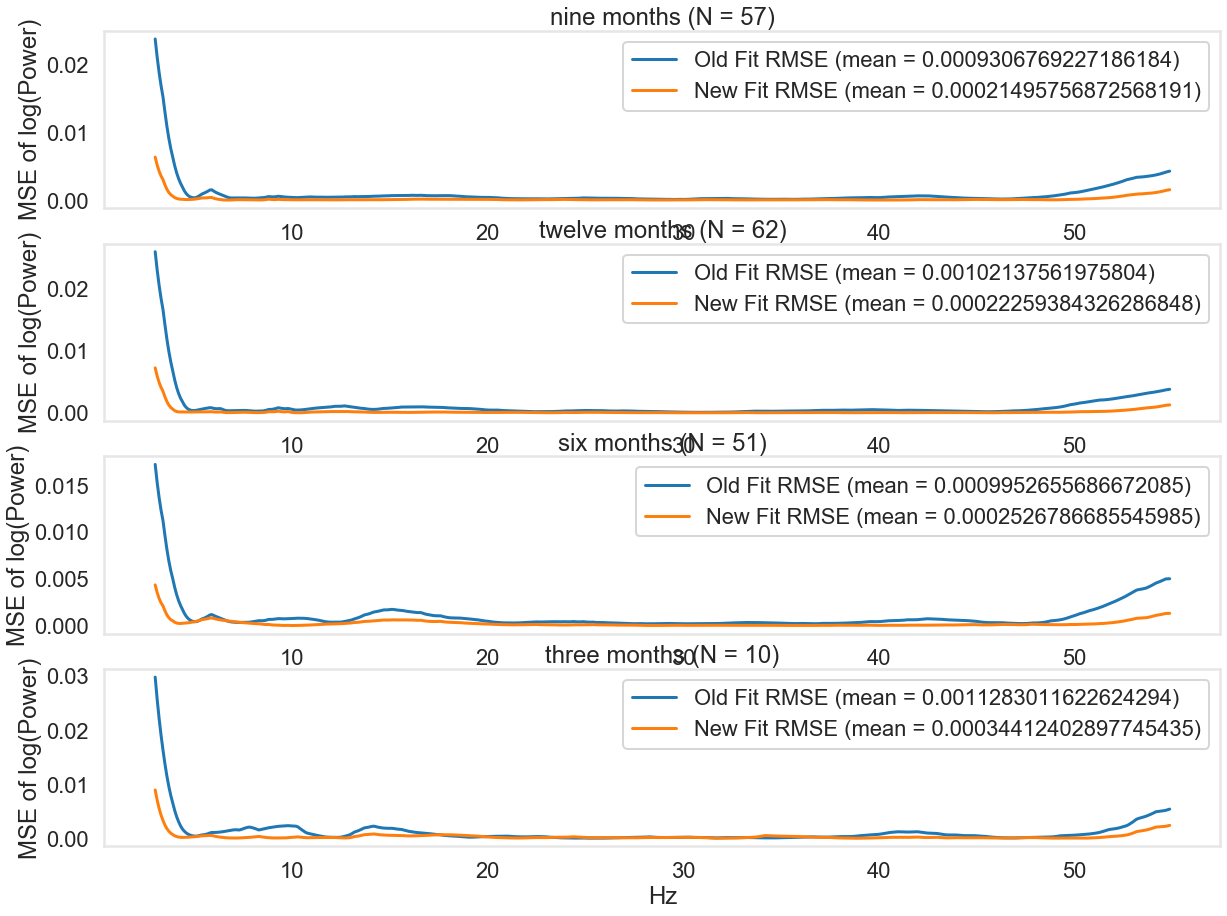

In [ ]:
#RUN BATCH COMPARISON
#Designate which dataframe you are running - here we run dfLRC (only the low risk controls without autism)
#Graphs mean standard error across the power spectra for original 'old' and new versions of FOOOF. 
err, err0, fms, fm0s, sampNums, fitDF, aperiodicDF, peaksDF = groupCompare(dfLRC)

In [ ]:
#Check to ensure no subjects were dropped
set(dfEEGall.groupby('Age_months').get_group(3).StudyID) == set(fitDF.groupby('Age_months').get_group('three').StudyID)
set(dfEEGall.groupby('Age_months').get_group(6).StudyID) == set(fitDF.groupby('Age_months').get_group('six').StudyID)
set(dfEEGall.groupby('Age_months').get_group(9).StudyID) == set(fitDF.groupby('Age_months').get_group('nine').StudyID)
set(dfEEGall.groupby('Age_months').get_group(12).StudyID) == set(fitDF.groupby('Age_months').get_group('twelve').StudyID)

False

In [ ]:
#Get errors by StudyID--> for finding outliers
errSums = {sampNums[t]: sum(err['six'][t,:]) for t in range(err['six'].shape[0])}

In [ ]:
#Isolate New FOOOF outputs
fitDF_new = fitDF.groupby('fit_version').get_group('new')
fitDF_old = fitDF.groupby('fit_version').get_group('old')
aperiodicDF_new = aperiodicDF.groupby('fit_version').get_group('new')
peaksDF_new = peaksDF.groupby('fit_version').get_group('new')

In [ ]:
#Change age back to integer
aperiodicDF_new['Age_months'] = aperiodicDF_new['Age_months'].map({'three':3, 'six':6, 'nine':9, 'twelve':12})
peaksDF_new['Age_months'] = peaksDF_new['Age_months'].map({'three':3, 'six':6, 'nine':9, 'twelve':12})
fitDF_new['Age_months'] = fitDF_new['Age_months'].map({'three':3, 'six':6, 'nine':9, 'twelve':12})
fitDF_old['Age_months'] = fitDF_old['Age_months'].map({'three':3, 'six':6, 'nine':9, 'twelve':12})

/Users/carol/anaconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/carol/anaconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carol/anaconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [ ]:
#merge summary info
fitDF_new = pd.merge(fitDF_new, dfsummary, how = 'left')
aperiodicDF_new = pd.merge(aperiodicDF_new, dfsummary, how = 'left')
peaksDF_new = pd.merge(peaksDF_new, dfsummary, how = 'left')

In [ ]:
#add periodic "flatcurve" to fitDF dataframes
fitDF_new['flatcurve'] = fitDF_new['spectrum']-fitDF_new['ap_fit']
fitDF_old['flatcurve'] = fitDF_old['spectrum']-fitDF_old['ap_fit']

/Users/carol/anaconda2/envs/mne/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#Savecsvs. 
#aperiodicDF_new.to_csv('pathforcsv.csv')

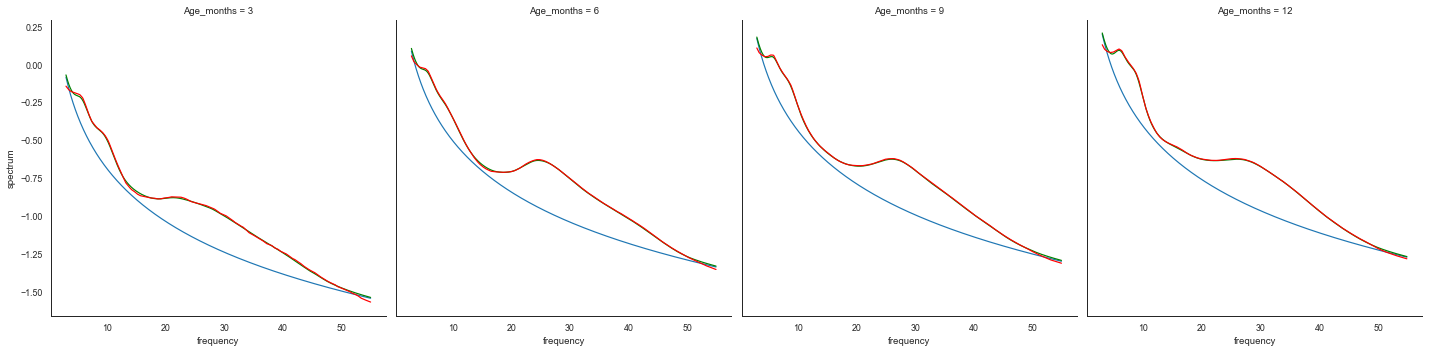

In [ ]:
#Compare actual and new fooof estimated spectrum
sns.set_context("paper")
sns.set_style("white")
g = sns.FacetGrid(fitDF_new, col = 'Age_months', height=5)
g = (g.map(sns.lineplot, 'frequency', 'ap_fit', palette = 'b', ci = None))
g = (g.map(sns.lineplot, 'frequency', 'fooof', color = 'green', ci = None))
g = (g.map(sns.lineplot, 'frequency', 'spectrum', color = 'red', ci = None))
g.add_legend();

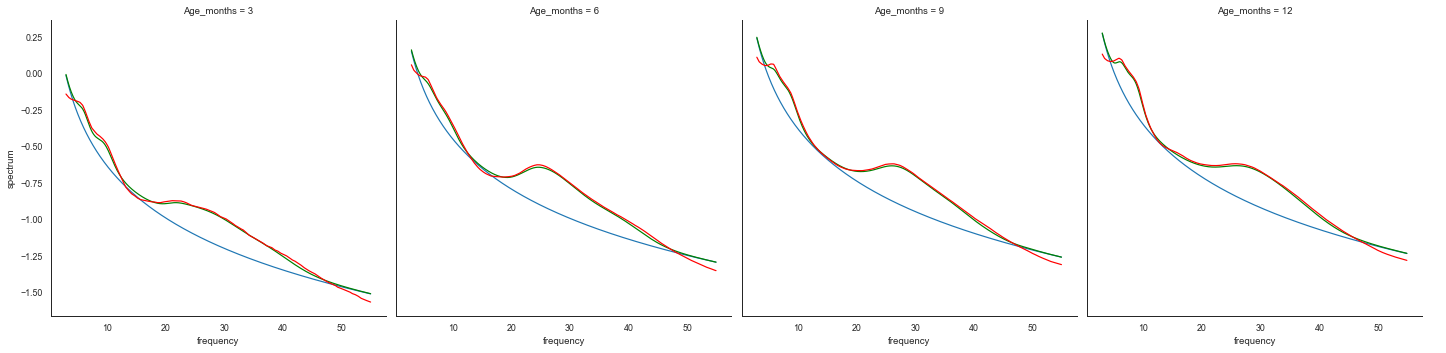

In [ ]:
#Compare actual and old fooof estimated spectrum
sns.set_context("paper")
sns.set_style("white")
g = sns.FacetGrid(fitDF_old, col = 'Age_months', height=5)
g = (g.map(sns.lineplot, 'frequency', 'ap_fit', palette = 'b', ci = None))
g = (g.map(sns.lineplot, 'frequency', 'fooof', color = 'green', ci = None))
g = (g.map(sns.lineplot, 'frequency', 'spectrum', color = 'red', ci = None))
g.add_legend();

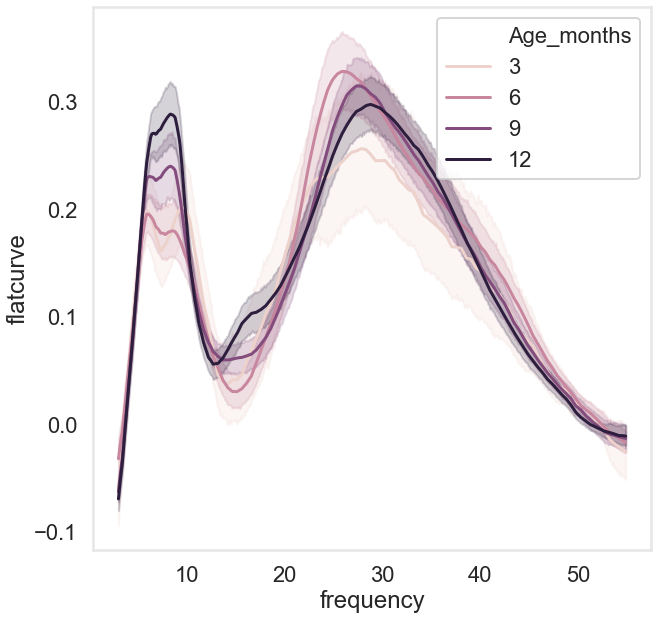

In [ ]:
#Graph FlatCurve
sns.set_style("white", {"axes.edgecolor": ".9"})
sns.set_context("poster")
ax = sns.lineplot(x='frequency', y='flatcurve', hue = 'Age_months', style='Age_months', 
                  markers=False, dashes=False, legend = 'full', data=fitDF_new)

fig = ax.figure
fig.set_size_inches(10, 10)

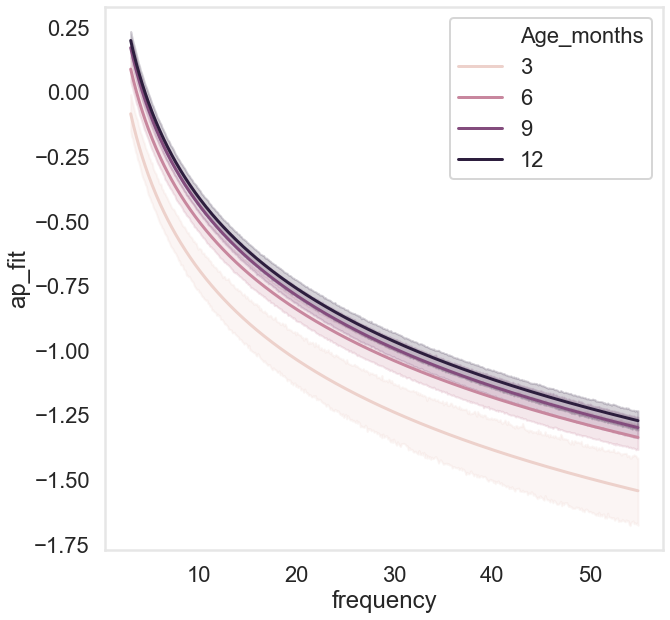

In [ ]:
#Graph FlatCurve
sns.set_style("white", {"axes.edgecolor": ".9"})
sns.set_context("poster")
ax = sns.lineplot(x='frequency', y='ap_fit', hue = 'Age_months', style='Age_months', 
                  markers=False, dashes=False, legend = 'full', data=fitDF_new)

fig = ax.figure
fig.set_size_inches(10, 10)